# PCA Regression of Housing Market Data

This notebook is the final project for "DTSA 5510: Unsupervised Algorithms in Machine Learning". All notebooks and datasets for the project can be accessed here: https://github.com/arwhit/Housing-Market-PCA


## Introduction
Buying or selling a home is often a big financial investment. There is a plethora of data that is recorded when a home is sold, but with so many features, it can become daunting to determine which features are actually driving the change in home price, especially when some of the features might be correlated. If we are trying to predict the sell price of a home, it would be convenient if there was a way to reduce all of the features down to a small, linearly-independent, combination that explains most of the variance in the dataset. There is a very powerful unsupervised learning technique that can be implemented to do this known as Principal Component Analysis (PCA).


In this project, PCA will be used for dimensionality reduction and latent feature extraction to build a linear regression model that predicts the sell price of homes. The PCA regression model will be compared to a linear regression model built using backward selection of the original features.


(The source for the original dataset, documentation for the libraries used in this project, and articles that I found useful for better understanding PCA can be found in the source section at the end of the notebook.)


##EDA

Before we dive into PCA, we need to take a look at the dataset. The original dataset was published in the Journal of Statistics Education Volume 19, Number 3(2011). It contained 2930 observations of sell price data with 80 different features. Of the features, 20 were continuous, 14 were discrete, 23 were nominal, and 23 were ordinal. Unfortunately, the original dataset is not publically accessible at this time. The CSV file imported here is a subset of the data that is available as part of a kaggle competition. It contains 1460 of the original observations. Let's explore the data to get a better idea of what we are working with.

In [19]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import math

In [20]:
#Import Dataset
data_URL='https://raw.githubusercontent.com/arwhit/Housing-Market-PCA/main/ames_train_dataset.csv'
data=pd.read_csv(data_URL)
#Create features dataframe
X=data.iloc[:,:-1]
#Create resposne dataframe
y=data.iloc[:, -1]

In [21]:
#Describe Data
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

The data contains interger, float, and object data types. Many of the features also have null values. These are things we will have to address in data cleaning. Lets take a look at the distrobution of numerical features.

array([[<Axes: title={'center': 'Means'}>,
        <Axes: title={'center': 'Maxs'}>],
       [<Axes: title={'center': 'Mins'}>, <Axes: >]], dtype=object)

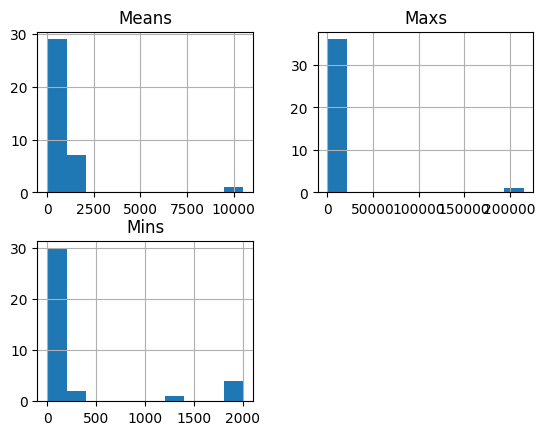

In [22]:
#Visualize Data
#Draw histograms of mean, max and min values for numeric feature
ndata=X.select_dtypes(include=['int64','float64'])
mean_vals=ndata.mean()
max_vals=ndata.max()
min_vals=ndata.min()
df = pd.DataFrame({'Means': mean_vals, 'Maxs': max_vals, 'Mins': min_vals})
df.hist()


It can be seen that most numerical observations have a range of different values with some features being several orders of magnitude higher than others. This implies we will need to scale the data.


**Note: When we build a linear regression model using the original features, we need to create a feature correlation matrix and remove features that are too correlated. If we don't do this, we risk building a model that violates linear regression assumptions. When features are correlated, we also have to be selective on which feature is more appropriate to remove based on our domain knowledge of what the variables represent. This becomes increasingly tedious when we have many features. However, The latent features created during PCA are constructed from the correlation matrix in a way that ensures they are not correlated which eliminates the need for this step. We will revisit feature correlation when we use a purely supervised approach to construct a linear regression model, but it is purposefully skipped here to demonstrate the power of PCA.**


Now let's look at Sell Price, the response variable.

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: SalePrice
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB
None
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


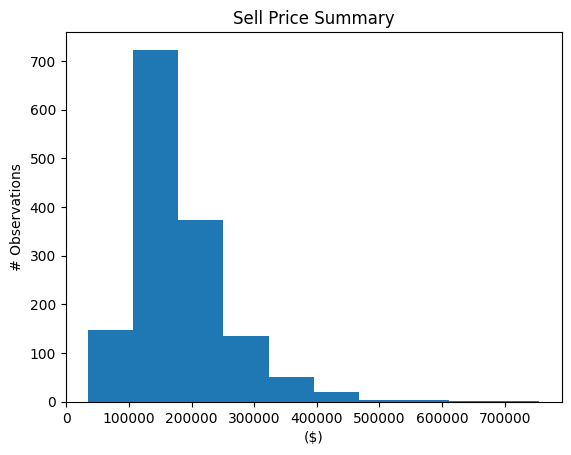

In [23]:
print(y.info())
print(y.describe())
plt.hist(y)
plt.xlabel('($)')
plt.ylabel('# Observations')
plt.title("Sell Price Summary")
plt.show()

There are no missing values in the response variable, but there are a few outliers that will need to be dropped during data cleaning

## Data Preprocessing Part 1: Data Cleaning and Splitting


The first portion of this step will be data cleaning. As seen above, there are several features that have null values.


Categories where null values are clearly missing values are: LotFrontage, MasVnrType, MasVnrArea, and Electrical. We will impute null values in these categories by using the mode of the column.


However, careful inspection of the data description provided with the dataset reveals NA values in most categorical variables indicate that the home does not have the feature. For example an NA value in the category "GarageType'' indicates the property has no garage. This type of classification makes it difficult to know if the home does not have a feature or if the feature was not recorded. We will assume in most cases that the null values indicate the property does not have the feature. PCA cannot handle null values so we will need to relabel null values with the string "FA" to indicate the feature is absent from the home in object type columns.


GarageYearBuilt is the only remaining float datatype with null values. We will impute missing values as the column average


We can also drop the Id, MiscVal, and MiscFeature as they are not meaningful to the analysis.


In [24]:
#Impute Clearly Missing Values
features_to_impute=['LotFrontage','MasVnrType','MasVnrArea','Electrical']
for feature in features_to_impute:
  most_common=X[feature].mode()[0]
  X[feature]=X[feature].fillna(most_common)

#Impute null values in GarageYrBlt
most_common=X['GarageYrBlt'].mode()[0]
X['GarageYrBlt']=X['GarageYrBlt'].fillna(most_common)

#Replace null values with a string that indicates the feature is absent
X.fillna('FA', inplace=True)

#Drop Unnecessary Columns
X = X.drop(columns=['Id','MiscVal','MiscFeature'])

We will also need to make sure that categorical variables are encoded in a way that is conducive to modeling. Ordinal Encoding will be used for ordinal categories and boolean nominal categories. One Hot Encoding will be used for nominal categories. Due to the nature of One Hot Encoding, we will need to separate nominal categories from the dataset, complete the encoding, and then merge them back with the original dataset.

In [25]:
#Create list of ordinal features
ordinal_features=['LotShape','LandSlope','OverallQual','OverallCond','ExterQual',
                  'ExterCond','BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1',
                  'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu',
                  'GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC',
                  'Fence', 'SaleCondition','CentralAir']

#Implement ordinal encoding
encoder=LabelEncoder()
for feature in ordinal_features:
  vals=X[feature]#.to_list()
  X[feature]=encoder.fit_transform(vals)

#Create List of nominal features
nominal_features=['MSSubClass','MSZoning','Street','Alley','LandContour','Utilities',
                  'LotConfig','Neighborhood','Condition1','Condition2','BldgType',
                  'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                  'MasVnrType','Foundation','Heating','Electrical','GarageType',
                  'SaleType']

#Copy nominal features to new dataframe
OHC_features=X[nominal_features]
#Remove original features from the dataframe
X=X.drop(columns=nominal_features)
#Implement one hot encoding
OHC=OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OHC_features=OHC.fit_transform(OHC_features)
OHC_feature_names=OHC.get_feature_names_out()
OHC_df=pd.DataFrame(OHC_features, columns=OHC_feature_names)
#Add encoded features back to dataframe
X=pd.concat([X,OHC_df],axis=1)

**Note after one hot encoding our feature size grows from 80 original features to 238 features, this is because a new boolean feature is created to represent each instance of the original nominal category**

Let's also remove observations where the sales price was outside 3 standard deviations from the mean


In [26]:
df=pd.concat([X,y],axis=1)
df=df.loc[df['SalePrice'] <= 420000]
X_clean=df.iloc[:, :-1]
y_clean=df.iloc[:, -1]

We will standardize the data so that the effects of one feature are not "washed out" by a feature that is on a larger scale. This is a key step in PCA.

In [27]:
#standardize data
scaler=StandardScaler()
X_std=scaler.fit_transform(X_clean)

Lastly, we will need to split the data into a training and test dataset.

In [28]:
#Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_std, y_clean, test_size=0.25, random_state=5)

## Data Preprocessing Part 2: **Principal Component Analysis**
This section contains the primary focus of the project, conducting PCA. In this section, we will create a combination of latent features that are representative of the dataset. The sklearn.decomposition library will do most of the heavy lifting here, but I think there is some value in reviewing the steps that are going on in the background. In general we are doing the following:

1. Calculating the covariance matrix to determine how features are related
2. Calculating the eigenvalues and eigenvectors of the covariance matrix to determine the variance and direction of the principal components
3. Sorting the eigenvalues in descending order so that the principal components are organized from most to least explained variance
4. Choosing the number of principal components to keep
5. Transforming the data from the very high dimensional original feature space to the principal component space which in most cases will be lower dimensional.

When we conduct PCA we are able to ensure model features are linearly independent and do not have to manually select original features to include in the model. The benefits can be very powerful in building an algorithm where prediction is the primary goal. However, we do lose some interpretability as to what our model features mean. For example, a 1 unit increase in lot size is easy to understand and explain, but it is difficult to explain what a 1 unit increase in a principal component that is a linear combination of lot size and number of bathrooms might mean.

We will start by building a PCA model that contains the same number of features as the original dataset and taking a look at the plot of explained variance vs number of components.


Text(0, 0.5, '% Explained Vairiance')

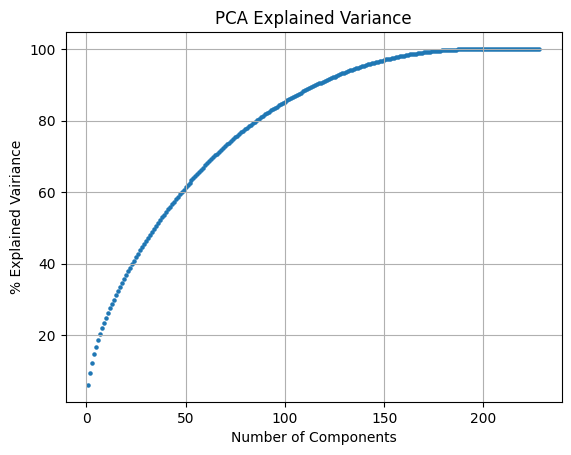

In [29]:
#Build the PCA model
pca = PCA()
X_pca=pca.fit_transform(X_train)
var_ratio=pca.explained_variance_ratio_
n_components=[]
percent_explained_variance=[]
#Calculate the total explained varience based on number of components
for i in range(pca.n_components_):
  n_components.append(i+1)
  percent_explained_variance.append(sum(var_ratio[0:i+1])*100)

#Plot Results
plt.scatter(n_components, percent_explained_variance, s=5)
plt.grid()
plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('% Explained Vairiance')

We see that over 85% of the explained variance in the model comes from only 100 components, but how well do the models predict?


## PCA Regression
We will build regression models from n=1 to n=238, the number of principal components, and evaluate the results. Since our primary goal here is prediction, not explanation, we will use RMSE as our metric of evaluation.

In [30]:
#transform original features to the latent feature space
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)

#Create linear regression models using the specified number of components and measure results
RMSE_train=[]
RMSE_test=[]
for i in range(pca.n_components_):
  X_train_n=X_train_pca[:,0:(i+1)]
  X_test_n=X_test_pca[:,0:(i+1)]
  reg = LinearRegression().fit(X_train_n, y_train)
  y1=reg.predict(X_train_n)
  RMSE_train.append(math.sqrt(np.square(y1-y_train).mean()))
  y2=reg.predict(X_test_n)
  RMSE_test.append(math.sqrt(np.square(y2-y_test).mean()))

print('The model that minimizes the RMSE in the test dataset has ',
      RMSE_test.index(min(RMSE_test))+1,'components and an RMSE of : ', min(RMSE_test))

The model that minimizes the RMSE in the test dataset has  130 components and an RMSE of :  30671.9130082285


Let's also plot the RMSE of the training and test dataset to get a visual representation of the model results. The model becomes so overfit at higher values of n that the plot becomes hard to interpret incremental changes at lower values of n so we will only plot the RMSE up to 150.



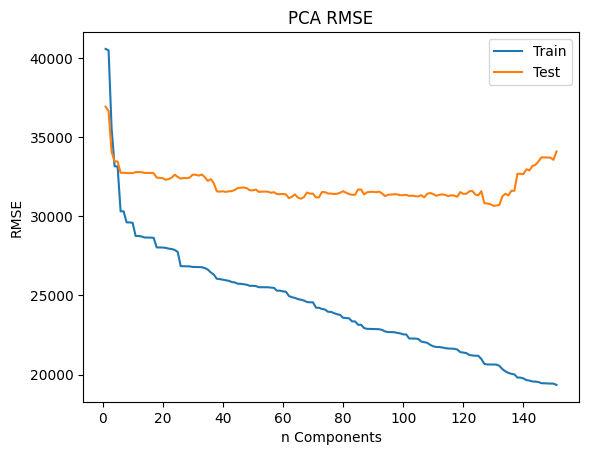

In [31]:
# Plot the data
plt.plot(n_components[0:151], RMSE_train[0:151], label="Train")
plt.plot(n_components[0:151], RMSE_test[0:151], label="Test")

# Set the title and labels
plt.title("PCA RMSE")
plt.xlabel("n Components")
plt.ylabel("RMSE")
plt.legend()

# Show the plot
plt.show()

While the best prediction model had 130 features, it is observed from the plot that similar prediction results can be achieved with fewer components. If we print out the RMSE of the first few models, we see only 6 features are needed to achieve similar results with the test data.

In [32]:
#Print the first 10 results to inspect further
RMSE_test[0:10]

[36936.22910971278,
 36651.19083560551,
 34079.76360425577,
 33481.281046524775,
 33469.205089922034,
 32755.151187577587,
 32755.72899228243,
 32737.497438659255,
 32732.009143945637,
 32732.322408709944]

##Linear Regression With Original Features using Backward Selection
Now let's build some linear regression models using a more supervised approach. It would be computationally expensive, and likely impractical, to build a model with all the features. We will consider only features that have a correlation coefficient with sales price that is >= 0.4 or < =-0.4. To avoid building a model with features that are correlated or collinear, we will also look at the correlation matrix. (We did not have to do this step during PCA because all of the principal components are constructed in a way where they are uncorrelated.)


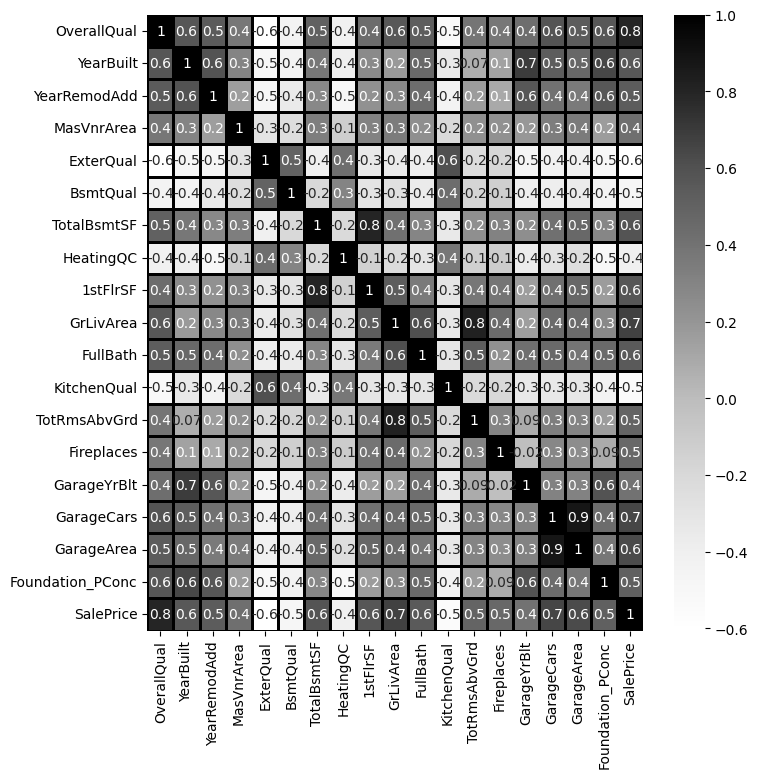

In [33]:
#Create a filtered daatframe with the top features
feature_corr=df.corr().iloc[-1,:].reset_index()
top_features=feature_corr.query("SalePrice <= -0.4 or SalePrice >= 0.4")['index'].tolist()
df_top=df.filter(top_features)

#Plot the correlation matrix
plt.figure(figsize=(8,8))
sns.heatmap(df_top.corr(),cmap="Greys",linewidth=1, linecolor="black", annot=True, fmt=".1g")
plt.show()

The following features share a correlation coefficient with a magnitude of 0.7 to another feature and will be removed:

* GarageYrBlt - this feature was correlated to the year the house was built
* TotalBsmtSF - this feature was correlated to the 1st floor SQFT
* TotlRmsAbvGrd - this feature was correlated to the above grade living area
* GarageArea- this feature was correlated to how many cars would fit into the garage

In [34]:
#Filter out features that ar etoo correlated to others
features_to_drop=['GarageYrBlt','TotalBsmtSF','TotRmsAbvGrd','GarageArea']
df_top=df_top.drop(columns=features_to_drop)

Now that we have filtered out heavily correlated features, let's separate the data back into the same training and test set from earlier then construct some models. With the PCA regression models, the features were already sorted in order of explained variance so there was no need to consider the order by which features were added to the regression model. Without PCA we have to be more selective with which combination of features are used to build the optimal model. Backward selection will be implemented as the method of feature selection.

In [35]:
#Split into training and test dataset
X=df_top.iloc[:, :-1]
y=df_top.iloc[:, -1]
X_std=pd.DataFrame(scaler.fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=5)

#Build the models and store the results
col_names=X.columns.tolist()
n_features=[]
RMSE_test=[]
RMSE_train=[]
feature_names=[]

for i in range(len(X_train.columns)):
  #Specify the number of features
  n=i+1
  n_features.append(n)
  #Create a forward selection model
  base_model=LinearRegression()
  bsm = RFE(base_model, n_features_to_select=n).fit(X_train,y_train)
  #make predictions
  y1=bsm.predict(X_train)
  RMSE_train.append(math.sqrt(np.square(y1-y_train).mean()))
  y2=bsm.predict(X_test)
  RMSE_test.append(math.sqrt(np.square(y2-y_test).mean()))
  #Extract features used
  feature_used=bsm.support_.tolist()
  feature_list=[]
  for i in range(len(feature_used)):
    if feature_used[i]==True:
      feature_list.append(col_names[i])
  feature_names.append(feature_list)

print('The model that minimizes the RMSE in the test dataset has ',
      RMSE_test.index(min(RMSE_test))+1,'components and an RMSE of : ', min(RMSE_test))

print('The features included in the best performing model were ',
      feature_names[RMSE_test.index(min(RMSE_test))])

The model that minimizes the RMSE in the test dataset has  7 components and an RMSE of :  33128.35158216375
The features included in the best performing model were  ['OverallQual', 'YearBuilt', '1stFlrSF', 'GrLivArea', 'KitchenQual', 'Fireplaces', 'GarageCars']


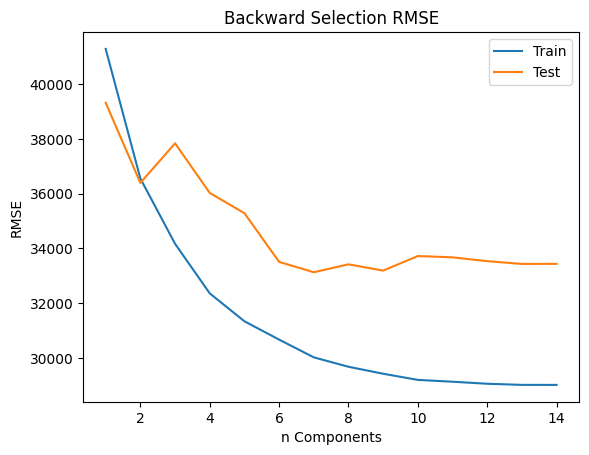

In [36]:
# Plot the data
plt.plot(n_features, RMSE_train, label="Train")
plt.plot(n_features, RMSE_test, label="Test")

# Set the title and labels
plt.title("Backward Selection RMSE")
plt.xlabel("n Components")
plt.ylabel("RMSE")
plt.legend()

# Show the plot
plt.show()

##Comparison of Results

Let's think about what RMSE represents in our model. Since the predicted values are home prices, the RMSE is a representation of how much predictions tend to deviate from the actual home price in units of dollars. We can see from the results that the RMSE of the best performing PCA model is lower than the best performing backward selection model by $2,457, or 7.4%. PCA was also a convenient unsupervised approach to construct a model where we were certain the model features were not correlated. However, the drawback is that the latent features created though PCA were not clearly interpretable. We know from the supervised model that the original features that have the heaviest impact on housing price are: 'OverallQual', 'YearBuilt', '1stFlrSF', 'GrLivArea', 'KitchenQual', 'Fireplaces', and 'GarageCars'. But we could not directly derive the same conclusion from the PCA model. If the primary goal of the model is purely prediction, my recommendation would be to use the PCA model, but if explanation is the primary goal, I would recommend a different approach.

###Sources

1. De Cock, D. (2011). Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project. Journal of Statistics Education, 19(3).

2. https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

3. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

4. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

5. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE

6. https://scikit-learn.org/stable/modules/preprocessing.html

7. https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c